In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython import display
display.set_matplotlib_formats("svg")



In [ ]:
iris = pd.read_csv("/content/drive/MyDrive/cleaned_data_2021_train.csv")

In [ ]:
iris = iris.drop(columns=['Unnamed: 0', 'activity_year', 'lei', 'denial_reason_1','denial_reason_2','denial_reason_3', 'denial_reason_4', 'applicant_ethnicity_1',
 'applicant_ethnicity_2',
 'applicant_ethnicity_3',
 'applicant_ethnicity_4',
 'applicant_ethnicity_5',
 'co_applicant_ethnicity_1',
 'co_applicant_ethnicity_2',
 'co_applicant_ethnicity_3',
 'co_applicant_ethnicity_4',
 'co_applicant_ethnicity_5',
 'applicant_ethnicity_observed',
 'co_applicant_ethnicity_observed',
 'applicant_race_1',
 'applicant_race_2',
 'applicant_race_3',
 'applicant_race_4',
 'applicant_race_5',
 'co_applicant_race_1',
 'co_applicant_race_2',
 'co_applicant_race_3',
 'co_applicant_race_4',
 'co_applicant_race_5',
 'applicant_race_observed',
 'co_applicant_race_observed',
 'aus_1',
 'aus_2',
 'aus_3',
 'aus_4',
 'aus_5',
 'applicant_sex',
 'co_applicant_sex',
 'applicant_sex_observed',
 'co_applicant_sex_observed','co_applicant_age','co_applicant_age_above_62','submission_of_application',
 'initially_payable_to_institution','applicant_credit_score_type',
 'co_applicant_credit_score_type',
 "hoepa_status",
 "purchaser_type"])

In [ ]:
iris = iris.drop(columns=['census_tract',"interest_rate", "rate_spread", "reverse_mortgage", "multifamily_affordable_units", "discount_points","origination_charges","total_loan_costs", "total_points_and_fees", "prepayment_penalty_term", "intro_rate_period", "lender_credits", 'derived_ethnicity', 'applicant_age_above_62'])

In [ ]:
iris.drop(iris[iris["combined_loan_to_value_ratio"] =="Exempt"].index, inplace = True)
print(iris.shape)
print(iris["action_taken"].unique())
print(sum(iris["action_taken"]==0))
iris.drop(iris[iris["property_value"] =="Exempt"].index, inplace = True)
print(iris.shape)
print(iris["action_taken"].unique())
print(sum(iris["action_taken"]==0))
iris.drop(iris[iris["loan_term"] =="Exempt"].index, inplace = True)
print(iris.shape)
print(iris["action_taken"].unique())
print(sum(iris["action_taken"]==0))
iris.drop(iris[iris["loan_term"].isna()].index, inplace= True)
print(iris.shape)
print(iris["action_taken"].unique())
print(sum(iris["action_taken"]==0))
iris.drop(iris[iris["property_value"].isna()].index, inplace= True)
print(iris.shape)
print(iris["action_taken"].unique())
print(sum(iris["action_taken"]==0))
iris.drop(iris[iris["debt_to_income_ratio"].isna()].index, inplace= True)
print(iris.shape)
print(iris["action_taken"].unique())
print(sum(iris["action_taken"]==0))
iris.drop(iris[iris["income"].isna()].index, inplace= True)
print(iris.shape)
print(iris["action_taken"].unique())
print(sum(iris["action_taken"]==0))
iris.drop(iris[iris["combined_loan_to_value_ratio"].isna()].index, inplace= True)
print(iris.shape)
print(iris["action_taken"].unique())
print(sum(iris["action_taken"]==0))
iris.drop(iris[iris["applicant_age"] =='8888'].index, inplace = True)
print(iris.shape)
print(iris["action_taken"].unique())
print(sum(iris["action_taken"]==0))
iris.drop(iris[iris["applicant_age"] =='9999'].index, inplace = True)
print(iris.shape)
print(iris["action_taken"].unique())
print(sum(iris["action_taken"]==0))

In [ ]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="http")
location = geolocator.geocode("TX")
print(location.longitude, location.latitude)

In [ ]:
state_to_long_lat = {}

longitudes = []
latitudes = []

for state in iris['state_code']:
  if state not in state_to_long_lat:
    print(state)
    state_to_long_lat[state] = geolocator.geocode(state).longitude, geolocator.geocode(state).latitude
  longitudes.append(state_to_long_lat[state][0])
  latitudes.append(state_to_long_lat[state][1])

iris['longitude'] = longitudes
iris['latitude'] = latitudes


In [ ]:
iris=iris.drop(columns=["derived_msa_md", "state_code", "county_code"])

In [ ]:
import math

iris['conforming_loan_limit'].unique()
iris.loc[iris['conforming_loan_limit'] == "C", "conforming_loan_limit"] = 1
iris.loc[iris['conforming_loan_limit'] == "NC", "conforming_loan_limit"] = 0
iris.loc[iris['conforming_loan_limit'] == "U", "conforming_loan_limit"] = 2
iris.loc[iris['conforming_loan_limit'].isna(), "conforming_loan_limit"] = 2

iris['conforming_loan_limit']=iris['conforming_loan_limit'].astype(int)

In [ ]:
iris.loc[iris['derived_loan_product_type'] == "Conventional:First Lien", "derived_loan_product_type"] = 0
iris.loc[iris['derived_loan_product_type'] == "FHA:First Lien", "derived_loan_product_type"] = 0
iris.loc[iris['derived_loan_product_type'] == "VA:First Lien", "derived_loan_product_type"] = 0
iris.loc[iris['derived_loan_product_type'] == "FSA/RHS:First Lien", "derived_loan_product_type"] = 0
iris.loc[iris['derived_loan_product_type'] == 'Conventional:Subordinate Lien', "derived_loan_product_type"] = 1
iris.loc[iris['derived_loan_product_type'] == 'VA:Subordinate Lien', "derived_loan_product_type"] = 1
iris.loc[iris['derived_loan_product_type'] == 'FSA/RHS:Subordinate Lien', "derived_loan_product_type"] = 1
iris.loc[iris['derived_loan_product_type'] == 'FHA:Subordinate Lien', "derived_loan_product_type"] = 1
iris['derived_loan_product_type']=iris['derived_loan_product_type'].astype(int)
iris['derived_loan_product_type'].unique()

In [ ]:
iris.loc[iris["derived_dwelling_category"]=='Single Family (1-4 Units):Site-Built', "derived_dwelling_category"]=0
iris.loc[iris["derived_dwelling_category"]=='Single Family (1-4 Units):Manufactured', "derived_dwelling_category"]=0
iris.loc[iris["derived_dwelling_category"]=='Multifamily:Site-Built', "derived_dwelling_category"]=1
iris.loc[iris["derived_dwelling_category"]=='Multifamily:Manufactured', "derived_dwelling_category"]=1
iris["derived_dwelling_category"]=iris["derived_dwelling_category"].astype(int)
iris["derived_dwelling_category"].unique()

In [ ]:
iris.loc[iris["applicant_age"]=='<25', "applicant_age"]=0
iris.loc[iris["applicant_age"]=='25-34', "applicant_age"]=1
iris.loc[iris["applicant_age"]=='35-44', "applicant_age"]=2
iris.loc[iris["applicant_age"]=='45-54', "applicant_age"]=3
iris.loc[iris["applicant_age"]=='55-64', "applicant_age"]=4
iris.loc[iris["applicant_age"]=='65-74', "applicant_age"]=5
iris.loc[iris["applicant_age"]=='>74', "applicant_age"]=6
iris["applicant_age"]=iris["applicant_age"].astype(int)

In [ ]:
iris.loc[iris["derived_sex"]=='Joint', "derived_sex"]=0
iris.loc[iris["derived_sex"]=='Male', "derived_sex"]=1
iris.loc[iris["derived_sex"]=='Female', "derived_sex"]=2
iris.loc[iris["derived_sex"]=='Sex Not Available', "derived_sex"]=3
iris["derived_sex"]=iris["derived_sex"].astype(int)

In [ ]:
iris.drop(iris[iris["debt_to_income_ratio"] =="Exempt"].index, inplace = True)
print(iris.shape)
print(iris["action_taken"].unique())

In [ ]:
import random

iris.loc[iris["debt_to_income_ratio"]=='<20%', "debt_to_income_ratio"]=str(random.randint(0, 21))+"%"
iris.loc[iris["debt_to_income_ratio"]=='20%-<30%', "debt_to_income_ratio"]='25%'
iris.loc[iris["debt_to_income_ratio"]=='30%-<36%', "debt_to_income_ratio"]='33%'
iris.loc[iris["debt_to_income_ratio"]=='50%-60%', "debt_to_income_ratio"]='55%'
iris.loc[iris["debt_to_income_ratio"]=='>60%', "debt_to_income_ratio"]=str(random.randint(61, 100))+"%"
iris["debt_to_income_ratio"]=iris["debt_to_income_ratio"].str.rstrip('%')
print(sum(iris['debt_to_income_ratio'].isna()))
iris['debt_to_income_ratio']=iris['debt_to_income_ratio'].astype(int)

In [ ]:
iris.loc[iris["total_units"]=='5-24', "total_units"]='5'
iris.loc[iris["total_units"]=='25-49', "total_units"]='6'
iris.loc[iris["total_units"]=='50-99', "total_units"]='7'
iris.loc[iris["total_units"]=='100-149', "total_units"]='8'
iris.loc[iris["total_units"]=='>149', "total_units"]='9'
iris["total_units"]=iris["total_units"].astype('int')

In [ ]:
iris["combined_loan_to_value_ratio"]=iris["combined_loan_to_value_ratio"].apply(pd.to_numeric)
iris["loan_term"]=iris["loan_term"].apply(pd.to_numeric)
iris["property_value"]=iris["property_value"].apply(pd.to_numeric)


### End of Data Cleaning / Model Training Time :\)

In [ ]:
iris = pd.read_csv("/content/drive/MyDrive/cleaned_data_2021_train.csv")

In [ ]:
iris.drop(iris[iris["derived_race"] =="Free Form Text Only"].index, inplace = True)

iris.loc[iris["derived_race"]=='White', "derived_race"]=0
iris.loc[iris["derived_race"]=='Black or African American', "derived_race"]=1
iris.loc[iris["derived_race"]=='Joint', "derived_race"]=1
iris.loc[iris["derived_race"]=='Asian', "derived_race"]=1
iris.loc[iris["derived_race"]=='2 or more minority races', "derived_race"]=1
iris.loc[iris["derived_race"]=='Native Hawaiian or Other Pacific Islander', "derived_race"]=1
iris.loc[iris["derived_race"]=='American Indian or Alaska Native', "derived_race"]=1
iris["derived_race"]=iris["derived_race"].astype(int)
iris["derived_race"]=iris["derived_race"].apply(pd.to_numeric)

In [ ]:
races=pd.DataFrame(iris['derived_race'], columns=["derived_race"])
iris=iris.drop(columns=["Unnamed: 0"])  #save race as seperate dataframe, but when testing you have to drop the column
#iris=iris.drop(columns=["derived_race"])

In [ ]:
# also want to normalize all data points from 0 to 1 so they scale relatively
iris_input = iris
iris_input = (iris_input - iris_input.mean())/iris_input.std() #when testing you have to run this line on whatever dataset variable to normalize the data

In [ ]:
X = torch.tensor(iris_input.drop("action_taken", axis=1).values, dtype=torch.float)
y = torch.tensor(
    [0 if i == 0 else 1 for i in iris["action_taken"]],
    dtype=torch.long
)

print(X.shape, y.shape)

torch.Size([428349, 36]) torch.Size([428349])


In [ ]:
# Hyperparameters
num_epochs = 80
learning_rate = 1e-3
batch_size = 16


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=len(test_data.tensors[0]))

print("Training data batches:")
for X, y in train_loader:
    print(X.shape, y.shape)

print("\nTest data batches:")
for X, y in test_loader:
    print(X.shape, y.shape)

Streaming output truncated to the last 5000 lines.
torch.Size([16, 36]) torch.Size([16])
torch.Size([16, 36]) torch.Size([16])
torch.Size([16, 36]) torch.Size([16])
torch.Size([16, 36]) torch.Size([16])
torch.Size([16, 36]) torch.Size([16])
torch.Size([16, 36]) torch.Size([16])
torch.Size([16, 36]) torch.Size([16])
torch.Size([16, 36]) torch.Size([16])
torch.Size([16, 36]) torch.Size([16])
torch.Size([16, 36]) torch.Size([16])
torch.Size([16, 36]) torch.Size([16])
torch.Size([16, 36]) torch.Size([16])
torch.Size([16, 36]) torch.Size([16])
torch.Size([16, 36]) torch.Size([16])
torch.Size([16, 36]) torch.Size([16])
torch.Size([16, 36]) torch.Size([16])
torch.Size([16, 36]) torch.Size([16])
torch.Size([16, 36]) torch.Size([16])
torch.Size([16, 36]) torch.Size([16])
torch.Size([16, 36]) torch.Size([16])
torch.Size([16, 36]) torch.Size([16])
torch.Size([16, 36]) torch.Size([16])
torch.Size([16, 36]) torch.Size([16])
torch.Size([16, 36]) torch.Size([16])
torch.Size([16, 36]) torch.Size([16])

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(in_features=36, out_features=512)
        # self.hidden_1 = nn.Linear(in_features=256, out_features=512)
        self.output = nn.Linear(in_features=512, out_features=1)

    def forward(self, x):
        x = F.sigmoid(self.input(x))
        # x = F.sigmoid(self.hidden_1(x))
        return F.sigmoid(self.output(x))


model = Net()
print(model)

Net(
  (input): Linear(in_features=36, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=1, bias=True)
)


In [ ]:
test_accuracies = []

In [ ]:
X, y = next(iter(test_loader))
model.eval()
pred_labels = torch.tensor([0 if pred < 0.5 else 1 for pred in model(X)])
test_acc = 100 * torch.mean((pred_labels == y).float()).item()
test_accuracies.append(test_acc)
print(test_acc)

In [ ]:
train_accuracies, test_accuracies = [], []

loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    # Train set
    train_loss = []

    for X, y in train_loader:
        optimizer.zero_grad()

        preds = model(X.cpu())
        pred_labels = torch.tensor([0 if pred < 0.5 else 1 for pred in preds]) #torch.argmax(preds, axis=1)

        #print("labels", pred_labels)

        loss = loss_function(preds.reshape(-1).float().cpu(), y.float().cpu())

        train_loss += [torch.mean((pred_labels == y).float()).item()]
        # print("vals", loss)
        loss.backward()
        optimizer.step()
        # print("pred labels", torch.mean((pred_labels == y).float()).item())
    train_acc =  100 * np.mean(train_loss)
    train_accuracies.append(train_acc)

    # Test set
    model.eval()
    X, y = next(iter(test_loader))
    pred_labels = torch.tensor([0 if pred < 0.5 else 1 for pred in model(X)])
    test_acc = 100 * torch.mean((pred_labels == y).float()).item()
    test_accuracies.append(test_acc)

    if True: #epoch%10 == 1:
      print("test: ", test_acc, " train: ", train_acc)

test:  79.32998538017273  train:  78.75193428766138
test:  79.53309416770935  train:  79.27114876676468
test:  79.60312962532043  train:  79.4324366688361
test:  79.7443687915802  train:  79.52765030752478
test:  79.77355122566223  train:  79.61139995735202
test:  79.8179030418396  train:  79.6998185772045
test:  79.93696928024292  train:  79.75984819185412
test:  79.93346452713013  train:  79.78465209511306
test:  79.79573011398315  train:  79.84805837550498
test:  79.989492893219  train:  79.88707762504116
test:  79.63581085205078  train:  79.90875498583274
test:  80.02101182937622  train:  80.02910602575858
test:  80.02684712409973  train:  80.00630310953404
test:  80.05836606025696  train:  80.02977302143671
test:  79.80506420135498  train:  80.06458186042421
test:  79.61946725845337  train:  80.11031275437162
test:  80.01750707626343  train:  80.13119805770847
test:  80.10038733482361  train:  80.18247335356082
test:  80.1657497882843  train:  80.13528340648053
test:  80.154079198

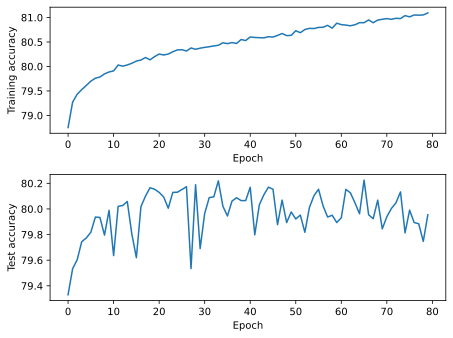

In [ ]:
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(nrows=2, ncols=1)

ax = fig.add_subplot(gs[0, 0])
ax.plot(train_accuracies)
ax.set_xlabel("Epoch")
ax.set_ylabel("Training accuracy")

ax = fig.add_subplot(gs[1, 0])
ax.plot(test_accuracies)
ax.set_xlabel("Epoch")
ax.set_ylabel("Test accuracy")

fig.align_labels()
plt.show()

In [ ]:
model.eval()
input = torch.zeros(36)
input[25] = 0
print(model(input))
input[25] = 1
print(model(input))

tensor([0.0539], grad_fn=<SigmoidBackward0>)
tensor([0.0023], grad_fn=<SigmoidBackward0>)


In [ ]:
torch.save(model.state_dict(),"mortgage_applications_model.pt")